In [1]:
# 7.1
# 임포트하기

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# gpu 설정
if torch.cuda.is_available():
    device = torch.device('cuda')          
else:
    device = torch.device('cpu')
    
print('device:', device)

device: cuda


### Hyperparameters (Mnist 학습 위해)
---

In [3]:
# 7.2
num_epochs = 30        # 에폭 수
num_classes = 10       # 분류 클래스 수 (0~9까지의 숫자)
batch_size = 1000      # 배치 사이즈
learning_rate = 0.001  # 학습률

### Load dataset (Mnist)
---

In [4]:
# 7.3
# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                           train=True, 
                                           transform=transforms.ToTensor(),
                                           download=True)

test_dataset = torchvision.datasets.MNIST(root='./mnist_data/',
                                          train=False, 
                                          transform=transforms.ToTensor())

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

100.0%


Extracting ./mnist_data/MNIST\raw\train-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



100.0%


Extracting ./mnist_data/MNIST\raw\train-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



100.0%


Extracting ./mnist_data/MNIST\raw\t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST\raw



100.0%

Extracting ./mnist_data/MNIST\raw\t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST\raw



### Progress monitor
---

In [5]:
from IPython.display import HTML, display


# Custom IPython progress bar for training
class ProgressMonitor(object):
    
    tmpl = """
        <table style="width: 100%;">
            <tbody>
                <tr>
                    <td style="width: 30%;">
                     <b>Loss: {loss:0.4f}</b> &nbsp&nbsp&nbsp {value} / {length}
                    </td>
                    <td style="width: 70%;">
                        <progress value='{value}' max='{length}', style='width: 100%'>{value}</progress>
                    </td>
                </tr>
            </tbody>
        </table>        
        """

    def __init__(self, length):
        self.length = length
        self.count = 0
        self.display = display(self.html(0, 0), display_id=True)
        
    def html(self, count, loss):
        return HTML(self.tmpl.format(length=self.length, value=count, loss=loss))
        
    def update(self, count, loss):
        self.count += count
        self.display.update(self.html(self.count, loss))

### Define CNN models
___

* nn.Conv2d(in_channels=C, out_channels=FN, kernel_size=FH)

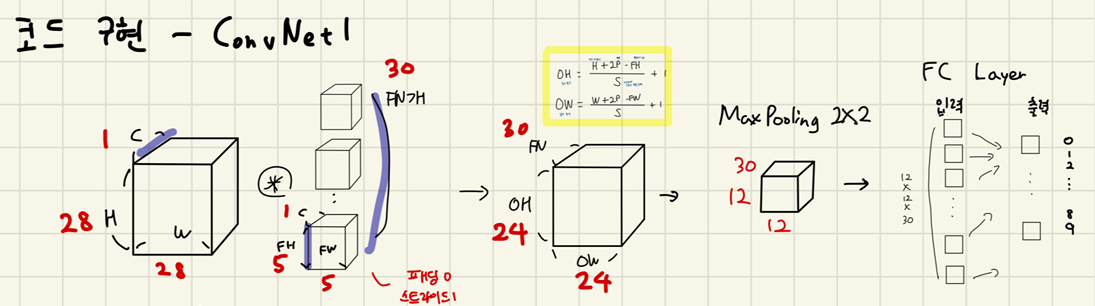

In [6]:
class ConvNet1(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        
        # nn.Sequential 정의 - 여러 레이어를 순차적으로 그룹화
        self.layer1 = nn.Sequential(
            # Conv2d - conv layer (입력 채널 1, 출력 채널 30, 필터사이즈 5x5, 스트라이드 1
            nn.Conv2d(1, 30, kernel_size=5, stride=1, padding=0),
            # BatchNorm2d - 배치정규화 layer, 채널은 30
            nn.BatchNorm2d(30),
            nn.ReLU(),
            # MaxPool2d - 2x2 max pool
            nn.MaxPool2d(kernel_size=2, stride=2))

        # fc layer - 입력: 12*12*30 출력: num_classes
        self.fc = nn.Linear(12*12*30, num_classes)
    def forward(self, x):
        # layer1 통과
        out = self.layer1(x) # (100,30,12,12) 로 나옴
        # fc layer 입력 전 reshape -> ( 미니배치 사이즈, 나머지는 일렬로 )
        out = out.reshape(out.size(0), -1) # (100, 30*12*12) 로 reshape
        # fc layer 통과
        out = self.fc(out)
        return out

In [7]:
# 7.7 모델 생성

model = ConvNet1(num_classes).to(device)

In [8]:
# 7.8 손실함수 - Cross entropy loss, optimizer - Adam
# 출력 class 가 여러개(10개) 이므로 crossentropy 사용

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

### Train
---

In [9]:
# 7.9 Train

# train 함수
def train():
    # 훈련 모드
    model.train()

    # progress bar 생성
    batch_loss_list = []
    progress = ProgressMonitor(length=len(train_dataset))

    for batch, target in train_loader:
        # train batch를 GPU로
        batch, target = batch.to(device), target.to(device)

        # 순전파
        output = model( batch )

        # 손실계산
        loss = loss_func( output, target )

        # 기울기 초기화
        optimizer.zero_grad()
        # 기울기 계산
        loss.backward()
        # 가중치 갱신
        optimizer.step()
        
        # update progress bar
        batch_loss_list.append(loss.item())
        progress.update(batch.shape[0], sum(batch_loss_list)/len(batch_loss_list) )

In [10]:
# test 함수
def test():
    # test 모드
    model.eval()

    correct = 0

    # no_grad to save memory
    with torch.no_grad():
        for batch, target in test_loader:
        # test batch를 GPU로
            batch, target = batch.to(device), target.to(device)
            
            # 순전파
            output = model( batch )
            
            # 최고 인덱스
            output = torch.argmax(output, 1)
            
            # 정답과 비교 후 correct 누적
            correct += (output == target).sum().item()
        
    # 정확도 계산
    acc = 100 * float(correct) / len(test_dataset)
    print( 'Test accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_dataset), acc ) )

In [11]:
# main loop

for epoch in range(num_epochs):
    train()
    test()

Loss: 0.4284 60000 / 60000,60000


Test accuracy: 9490/10000 (94.90%)


Loss: 0.1548 60000 / 60000,60000


Test accuracy: 9668/10000 (96.68%)


Loss: 0.1054 60000 / 60000,60000


Test accuracy: 9732/10000 (97.32%)


Loss: 0.0799 60000 / 60000,60000


Test accuracy: 9803/10000 (98.03%)


Loss: 0.0658 60000 / 60000,60000


Test accuracy: 9804/10000 (98.04%)


Loss: 0.0560 60000 / 60000,60000


Test accuracy: 9825/10000 (98.25%)


Loss: 0.0489 60000 / 60000,60000


Test accuracy: 9809/10000 (98.09%)


Loss: 0.0434 60000 / 60000,60000


Test accuracy: 9837/10000 (98.37%)


Loss: 0.0393 60000 / 60000,60000


Test accuracy: 9842/10000 (98.42%)


Loss: 0.0356 60000 / 60000,60000


Test accuracy: 9851/10000 (98.51%)


Loss: 0.0337 60000 / 60000,60000


Test accuracy: 9847/10000 (98.47%)


Loss: 0.0306 60000 / 60000,60000


Test accuracy: 9847/10000 (98.47%)


Loss: 0.0279 60000 / 60000,60000


Test accuracy: 9852/10000 (98.52%)


Loss: 0.0258 60000 / 60000,60000


Test accuracy: 9855/10000 (98.55%)


Loss: 0.0244 60000 / 60000,60000


Test accuracy: 9854/10000 (98.54%)


Loss: 0.0228 60000 / 60000,60000


Test accuracy: 9839/10000 (98.39%)


Loss: 0.0212 60000 / 60000,60000


Test accuracy: 9861/10000 (98.61%)


Loss: 0.0203 60000 / 60000,60000


Test accuracy: 9862/10000 (98.62%)


Loss: 0.0179 60000 / 60000,60000


Test accuracy: 9850/10000 (98.50%)


Loss: 0.0174 60000 / 60000,60000


Test accuracy: 9852/10000 (98.52%)


Loss: 0.0158 60000 / 60000,60000


Test accuracy: 9861/10000 (98.61%)


Loss: 0.0139 60000 / 60000,60000


Test accuracy: 9855/10000 (98.55%)


Loss: 0.0139 60000 / 60000,60000


Test accuracy: 9849/10000 (98.49%)


Loss: 0.0120 60000 / 60000,60000


Test accuracy: 9855/10000 (98.55%)


Loss: 0.0115 60000 / 60000,60000


Test accuracy: 9857/10000 (98.57%)


Loss: 0.0102 60000 / 60000,60000


Test accuracy: 9851/10000 (98.51%)


Loss: 0.0099 60000 / 60000,60000


Test accuracy: 9858/10000 (98.58%)


Loss: 0.0096 60000 / 60000,60000


Test accuracy: 9841/10000 (98.41%)


Loss: 0.0086 60000 / 60000,60000


Test accuracy: 9860/10000 (98.60%)


Loss: 0.0080 60000 / 60000,60000


Test accuracy: 9865/10000 (98.65%)


## 참고: ConvNet2, ConvNet3

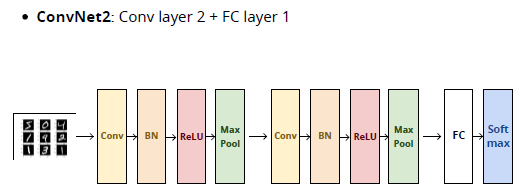

* nn.Conv2d(in_channels=C, out_channels=FN, kernel_size=FH)

In [ ]:
# 7.5 ConvNet2 - Conv layer 2 + fc layer 1

class ConvNet2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        # layer1 - nn.Sequential
        self.layer1 = nn.Sequential(
            # Conv2d - conv layer (입력 채널 1, 출력 채널 16, 필터사이즈 5x5, 스트라이드 1, 패딩 2)
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            # BatchNorm2d - 배치정규화 layer, 채널은 16
            nn.BatchNorm2d(16),
            nn.ReLU(),
            # MaxPool2d - 2x2 max pool
            nn.MaxPool2d(kernel_size=2, stride=2))

        # layer2 - nn.Sequential
        self.layer2 = nn.Sequential(
            # Conv2d - conv layer (입력 채널 16, 출력 채널 32, 필터사이즈 5x5, 스트라이드 1, 패딩 2)
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            # BatchNorm2d - 배치정규화 layer, 채널은 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            # MaxPool2d - 2x2 max pool
            nn.MaxPool2d(kernel_size=2, stride=2))

        # fc layer - 입력: 7*7*32 출력: num_classes
        self.fc = nn.Linear(7*7*32, num_classes)

    def forward(self, x):
        # layer1 통과
        out = self.layer1(x)
        # layer2 통과
        out = self.layer2(out)
        # fc layer 입력 전 reshape -> ( 미니배치 사이즈, 나머지는 일렬로 )
        out = out.reshape(out.size(0), -1)
        # fc layer 통과
        out = self.fc(out)
        return out

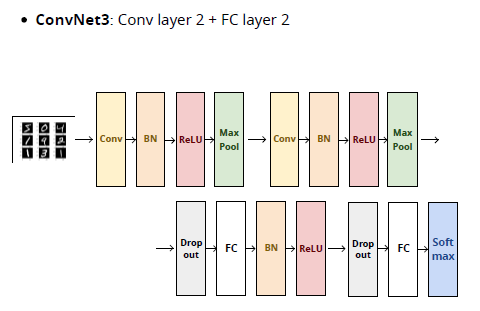

In [ ]:
# 7.6 2개의 ConvNet2 - Conv layer 2, fc layer 3

class ConvNet3(nn.Module):
        def __init__(self, num_classes=10):
            super().__init__()

            # layer1 - nn.Sequential
            self.layer1 = nn.Sequential(

                # Conv2d - conv layer (입력 채널 1, 출력 채널 16, 필터사이즈 5x5, 스트라이드 1, 패딩 2)
                nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
                # BatchNorm2d - 배치정규화 layer, 채널은 16
                nn.BatchNorm2d(16),
                nn.ReLU(),
                # MaxPool2d - 2x2 max pool
                nn.MaxPool2d(kernel_size=2, stride=2))

            # layer2 - nn.Sequential
            self.layer2 = nn.Sequential(

                # Conv2d - conv layer (입력 채널 16, 출력 채널 32, 필터사이즈 5x5, 스트라이드 1, 패딩 2)
                nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
                # BatchNorm2d - 배치정규화 layer, 채널은 32
                nn.BatchNorm2d(32),
                nn.ReLU(),
                # MaxPool2d - 2x2 max pool
                nn.MaxPool2d(kernel_size=2, stride=2))

            # fc - nn.Sequential
            self.fc = nn.Sequential(

                # 드롭아웃 (드롭아웃 ratio = 0.5)
                nn.Dropout(p = 0.5),
                # Linear layer - 입력: 32*7*7, 출력: 512
                nn.Linear(32 * 7 * 7, 512),
                # BatchNorm1d - 배치정규화 layer, 갯수는 512
                nn.BatchNorm1d(512),
                nn.ReLU(),
                # 드롭아웃 (드롭아웃 ratio = 0.5)
                nn.Dropout(p = 0.5),
                # Linear layer - 입력: 512, 출력: 10
                nn.Linear(512, 10),
                )